If you're opening this Notebook on colab, you will probably need to install the most recent versions of 🤗 Transformers and 🤗 Datasets. We will also need `scipy` and `scikit-learn` for some of the metrics. Uncomment the following cell and run it.

In [1]:
! pip --quiet install git+https://github.com/huggingface/transformers.git
! pip --quiet install git+https://github.com/huggingface/datasets.git
! pip --quiet install scipy sklearn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 4.2 MB/s 
     |████████████████████████████████| 895 kB 48.6 MB/s 
     |████████████████████████████████| 6.8 MB 42.1 MB/s 
     |████████████████████████████████| 61 kB 424 kB/s 
     |████████████████████████████████| 243 kB 3.8 MB/s 
     |████████████████████████████████| 132 kB 36.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
     |████████████████████████████████| 160 kB 49.5 MB/s 
     |████████████████████████████████| 192 kB 52.9 MB/s 
     |████████████████████████████████| 271 kB 49.2 MB/s 


In [2]:
import transformers
from google.colab import drive

print(transformers.__version__)

4.16.0.dev0


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/text-classification).

# Fine-tuning a model on a text classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).

The GLUE Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

We will see how to easily load the dataset for each one of those tasks and use the `Trainer` API to fine-tune a model on it. Each task is named by its acronym, with `mnli-mm` standing for the mismatched version of MNLI (so same training set as `mnli` but different validation and test sets):

In [3]:
# GLUE_TASKS = [
#     "cola",
#     "mnli",
#     "mnli-mm",
#     "mrpc",
#     "qnli",
#     "qqp",
#     "rte",
#     "sst2",
#     "stsb",
#     "wnli",
# ]

This notebook is built to run on any of the tasks in the list above, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [54]:
# task = "sst2"
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint ="bert-base-cased" # name from Hugging Face repository
batch_size = 6 # 16 too large

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [55]:
from datasets import load_dataset, load_metric

Apart from `mnli-mm` being a special code, we can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [56]:
# actual_task = "mnli" if task == "mnli-mm" else task
# dataset = load_dataset("glue", actual_task)
# metric = load_metric("glue", actual_task)

# dataset = load_dataset("glue", task)
# metric = load_metric("glue", task)

In [57]:
# dataset = datasets.load_dataset("imdb", split="test")
dataset = load_dataset("imdb")

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [58]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [59]:
dataset["train"][0]

{'label': 0,
 'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are f

In [60]:
# import numpy as np
# num_labels=len(np.unique(dataset["train"]["label"])) # luokkien lukumäärä
# print(np.unique(dataset["train"]["label"]))
# num_labels

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [61]:
# import datasets
# import random
# import pandas as pd
# from IPython.display import display, HTML


# def show_random_elements(dataset, num_examples=10):
#     assert num_examples <= len(
#         dataset
#     ), "Can't pick more elements than there are in the dataset."
#     picks = []
#     for _ in range(num_examples):
#         pick = random.randint(0, len(dataset) - 1)
#         while pick in picks:
#             pick = random.randint(0, len(dataset) - 1)
#         picks.append(pick)

#     df = pd.DataFrame(dataset[picks])
#     for column, typ in dataset.features.items():
#         if isinstance(typ, datasets.ClassLabel):
#             df[column] = df[column].transform(lambda i: typ.names[i])
#     display(HTML(df.to_html()))

In [62]:
# show_random_elements(dataset["train"])

In [63]:
for i in range(0,20000,4000):
  print(dataset["train"]["label"][i], "\t", dataset["train"]["text"][i])

0 	 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between,

In [64]:
dataset["train"] = dataset["train"].filter(lambda example, idx: idx % 10 == 0, with_indices=True)
# if index is divisible with 10, select the instance

len(dataset["train"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-2bb51c6f00c9430b.arrow


2500

In [65]:
dataset["validation"] = dataset["test"].filter(lambda example, idx: idx % 2 == 0, with_indices=True).filter(lambda example, idx: idx % 20 == 0, with_indices=True)
dataset["test"] = dataset["test"].filter(lambda example, idx: idx % 2 != 0, with_indices=True).filter(lambda example, idx: idx % 20 == 0, with_indices=True)

len(dataset["validation"]), len(dataset["test"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-cf0a4bebe61b82c7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f5cee140a9f911b7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-2d010b75dc07ab97.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-2beba353f71da13f.arrow


(625, 625)

In [66]:
del dataset["unsupervised"]
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 625
    })
})

In [67]:
print(dataset["train"].features)
dataset["train"].features["label"].str2int(values=["neg", "pos"]) # neg is encoded to 0 and pos to 1

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}


[0, 1]

The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [68]:
# metric
# TODO: F1-score

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [69]:
# import numpy as np

# fake_preds = np.random.randint(0, 2, size=(64,))
# fake_labels = np.random.randint(0, 2, size=(64,))
# metric.compute(predictions=fake_preds, references=fake_labels)

Note that `load_metric` has loaded the proper metric associated to your task, which is:

- for CoLA: [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)
- for MNLI (matched or mismatched): Accuracy
- for MRPC: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for QNLI: Accuracy
- for QQP: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for RTE: Accuracy
- for SST-2: Accuracy
- for STS-B: [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman's_Rank_Correlation_Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- for WNLI: Accuracy

so the metric object only computes the one(s) needed for your task.

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [70]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

You can directly call this tokenizer on one sentence or a pair of sentences:

In [71]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 8667, 117, 1142, 1141, 5650, 106, 102, 1262, 1142, 5650, 2947, 1114, 1122, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [72]:
# task_to_keys = {
#     "cola": ("sentence", None),
#     "mnli": ("premise", "hypothesis"),
#     "mnli-mm": ("premise", "hypothesis"),
#     "mrpc": ("sentence1", "sentence2"),
#     "qnli": ("question", "sentence"),
#     "qqp": ("question1", "question2"),
#     "rte": ("sentence1", "sentence2"),
#     "sst2": ("sentence", None),
#     "stsb": ("sentence1", "sentence2"),
#     "wnli": ("sentence1", "sentence2"),
# }

We can double check it does work on our current dataset:

In [73]:
# sentence1_key, sentence2_key = task_to_keys[task]
# if sentence2_key is None:
#     print(f"Sentence: {dataset['train'][0][sentence1_key]}")
# else:
#     print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
#     print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

In [74]:
print(f"Sentence: {dataset['train'][0]['text']}")

Sentence: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the arguments `truncation=True` and `padding='longest`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model, and all inputs will be padded to the maximum input length to give us a single input array. A more performant method that reduces the number of padding tokens is to write a generator or `tf.data.Dataset` to only pad each *batch* to the maximum length in that batch, but most GLUE tasks are relatively quick on modern GPUs either way.

In [75]:
# def preprocess_function(examples):
#     if sentence2_key is None:
#         return tokenizer(examples[sentence1_key], truncation=True)
#     return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [76]:
preprocess_function(dataset["train"][:5])

{'input_ids': [[101, 146, 12765, 146, 6586, 140, 19556, 19368, 13329, 118, 162, 21678, 2162, 17056, 1121, 1139, 1888, 2984, 1272, 1104, 1155, 1103, 6392, 1115, 4405, 1122, 1165, 1122, 1108, 1148, 1308, 1107, 2573, 119, 146, 1145, 1767, 1115, 1120, 1148, 1122, 1108, 7842, 1118, 158, 119, 156, 119, 10148, 1191, 1122, 1518, 1793, 1106, 3873, 1142, 1583, 117, 3335, 1217, 170, 5442, 1104, 2441, 1737, 107, 6241, 107, 146, 1541, 1125, 1106, 1267, 1142, 1111, 1991, 119, 133, 9304, 120, 135, 133, 9304, 120, 135, 1109, 4928, 1110, 8663, 1213, 170, 1685, 3619, 3362, 2377, 1417, 14960, 1150, 3349, 1106, 3858, 1917, 1131, 1169, 1164, 1297, 119, 1130, 2440, 1131, 3349, 1106, 2817, 1123, 2209, 1116, 1106, 1543, 1199, 3271, 1104, 4148, 1113, 1184, 1103, 1903, 156, 11547, 1162, 1354, 1164, 2218, 1741, 2492, 1216, 1112, 1103, 4357, 1414, 1105, 1886, 2492, 1107, 1103, 1244, 1311, 119, 1130, 1206, 4107, 8673, 1105, 6655, 10552, 3708, 2316, 1104, 8583, 1164, 1147, 11089, 1113, 4039, 117, 1131, 1144, 2673, 

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [77]:
pre_tokenizer_columns = set(dataset["train"].features)
encoded_dataset = dataset.map(preprocess_function, batched=True)
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-39ee2938194f3dcb.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b42357f7309e11a0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-7fe0e4608da9e213.arrow


Columns added by tokenizer: ['attention_mask', 'input_ids', 'token_type_ids']


In [78]:
encoded_dataset["train"].shape

(2500, 5)

In [79]:
for k, v in encoded_dataset["train"][0].items():
  print(k, v)

attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

Finally, we convert our datasets to `tf.data.Dataset`. There's a built-in method for this, so all you need to do is specify the columns you want (both for the inputs and the labels), whether the data should be shuffled, the batch size, and an optional collation function, that controls how a batch of samples is combined.

We'll need to supply a `DataCollator` for this. The `DataCollator` handles grouping each batch of samples together, and different tasks will require different data collators. In this case, we will use the `DataCollatorWithPadding`, because our samples need to be padded to the same length to form a batch. Remember to supply the `return_tensors` argument too - our data collators can handle multiple frameworks, so you need to be clear that you want TensorFlow tensors back.

In [80]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_test_dataset = encoded_dataset["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

## Fine-tuning the model

In [81]:
# To connect Google account to Colab
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [82]:
%%bash
# cd gdrive/MyDrive/bachelor_thesis
# mkdir model_checkpoints
# ls

In [83]:
file_path="/content/gdrive/MyDrive/bachelor_thesis/model_checkpoints/model.hdf5"

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `TFAutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels). We also need to get the appropriate loss function (SparseCategoricalCrossentropy for every task except STSB, which as a regression problem requires MeanSquaredError).

Note that all models in `transformers` compute loss internally too, and you can train on this loss value. This can be very helpful when the loss is not easy to specify yourself. To use this, pass the labels as a `labels` key in the input dictionary, and then compile the model without specifying a loss. You can see examples of this approach in several of the other TensorFlow notebooks.

In [84]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# from_logits: Whether y_pred is expected to be a logits tensor. 
# By default, we assume that y_pred encodes a probability distribution (from_logits=False). 

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=dataset["train"].features["label"].num_classes
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [85]:
# Metrics to follow while training
metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [107]:
from transformers import create_optimizer

num_epochs = 2 #5
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=metrics)

The `create_optimizer` function in the Transformers library creates a very useful `AdamW` optimizer with weight and learning rate decay. This performs very well for training most transformer networks - we recommend using it as your default unless you have a good reason not to! Note, however, that because it decays the learning rate over the course of training, it needs to know how many batches it will see during training.

In [87]:
# metric_name = "accuracy"

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last two arguments are to setup everything so we can push the model to the [Hub](https://huggingface.co/models) at the end of training. Remove the two of them if you didn't follow the installation steps at the top of the notebook, otherwise you can change the value of `push_to_hub_model_id` to something you would prefer.

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [88]:
# def compute_metrics(predictions, labels):
#     predictions = np.argmax(predictions, axis=1)
#     return metric.compute(predictions=predictions, references=labels)

#     # Partly adapted from UTU Textual Data Analysis course material:

# def compute_metrics(pred):
#     y_pred = pred.predictions.argmax(axis=1) 
#     # we get the probability distribution out and the highest is selected with argmax
#     y_true = pred.label_ids
#     TP = len([a and b for a, b in zip(y_pred, y_true) if a == 1 and b == 1])
#     TN = len([a and b for a, b in zip(y_pred, y_true) if a == 0 and b == 0])
#     FN = len([a and b for a, b in zip(y_pred, y_true) if a == 0 and b == 1])
#     FP = len([a and b for a, b in zip(y_pred, y_true) if a == 1 and b == 0])

#     ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
#     PRE = TP/(TP+FP) # Precision: share of relevant items
#     REC = TP/(TP+FN) # Recall: proportion of relevant items found
#     F1 = (2*((PRE*REC)/(PRE+REC))) # Balance between precision and recall
#     return {'accuracy': ACC,
#             'precision': PRE, 
#             'recall': REC,
#             'F1-score':F1
#             }

We can now finetune our model by just calling the `fit` method. Be sure to pass the TF datasets, and not the original datasets! We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TODO: early stopping, save best

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
mc_cb = ModelCheckpoint(filepath=file_path, 
                        monitor='val_loss', # true positive better metrics!
                        # monitor='auc',
                        verbose=1, 
                        save_best_only=True, 
                        save_weights_only=True, # only the weights are saved. To use them a model is needed but it can be saved elsewhere or restored from this notebook
                        save_freq='epoch', # save after every epoch
                        mode='auto')

history = model.fit(
    tf_train_dataset,
    verbose=1,
    epochs=3, 
    validation_data=tf_validation_dataset,
    callbacks=[mc_cb],
    ) 

# model.fit(
#     tf_train_dataset,
#     validation_data=tf_validation_dataset,
#     epochs=2#3,
#     # callbacks=[callback],
# )

Epoch 1/3


TypeError: ignored

In [104]:
import matplotlib.pyplot as plt

def plot_metrics(history):
  metrics =  ['loss']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(figsize=(6,6))
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel(name)
    plt.show()

In [105]:
type(history)

print(history.history.keys())

for k, v in history.history.items():
  print(k, v)


dict_keys(['loss', 'val_loss'])
loss [0.39979517459869385, 0.14169131219387054]
val_loss [0.3041481077671051, 0.2552860677242279]


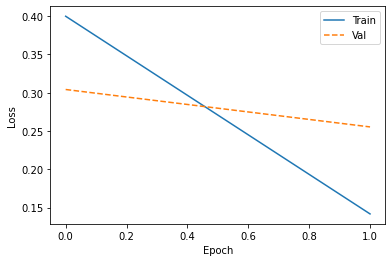

In [106]:
plot_metrics(history)

We can add Keras metrics during compilation above if we want to get live readouts during training, or we can use the `compute_metrics` function after training to compute the metrics specified for each task.

In [90]:
predictions = model.predict(tf_test_dataset)["logits"]

In [91]:
compute_metrics(predictions, np.array(encoded_dataset["test"]["label"]))
# compute_metrics(predictions, np.array(encoded_dataset[validation_key]["label"]))

NameError: ignored

## SHAP

In [ ]:
! pip --quiet install shap

In [ ]:
import shap
# https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores
# https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores#

# classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True)
# classifier(short_data[:2])

classifier = transformers.pipeline(task='sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)
short_data = [v[:500] for v in dataset["test"]["text"][:20]] # first 500 lettres from the first 20 test split texts
classifier(short_data[:2]) # pipeline predictions for the 2 first samples in the "short_data"
# Labels need to be int for the model, thus 'LABEL_0' and 'LABEL_1'
# TODO: fix labels

In [ ]:
type(short_data)

In [ ]:
# define the explainer
explainer = shap.Explainer(classifier)

In [ ]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

In [ ]:
shap.plots.text(shap_values[:,:,"LABEL_0"])